In [1]:
import pandas as pd
df_PR = pd.read_csv("out_PR_ALL.csv", sep='\t')
df_PR = df_PR.ix[:,1:] 

df_GC = pd.read_csv("out_GC_ALL.csv", sep='\t')
df_GC = df_GC.ix[:,1:] 


In [2]:
# merge back to original dataframe with deleted NaN's

df_big  = pd.DataFrame()

df_big = pd.merge(df_PR[['Organism','Kingdom','Size','Chr','url','RPR']], df_GC[['GC', 'Organism']],
                       how='left', on=['Organism'])


In [3]:
#DROP NAN, RESET INDEX otherwise - index match up problem with Xbmat, Xf later...

df_sub = df_big.dropna().reset_index(drop=True)
print df_sub.shape

(7449, 7)


In [4]:
df_sub.head(5)

,Organism,Kingdom,Size,Chr,url,RPR,GC
0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.236980,1.0,/genome/38191,3038.0,70.2000
1,Abaca bunchy top virus,Viruses,0.006422,6.0,/genome/6115,5.0,41.0385
2,Abalone herpesvirus Victoria/AUS/2009,Viruses,0.211518,1.0,/genome/15289,118.0,46.8000
3,Abalone shriveling syndrome-associated virus,Viruses,0.034952,1.0,/genome/6386,31.0,39.5000
4,Abelson murine leukemia virus,Viruses,0.005894,1.0,/genome/4841,3.0,55.2000


In [5]:
########API-CLasses from Open Tree of Life#############
###MODIFIED FROM OT-TNRS-MATCH-NAMES###################
#######################################################
#!/usr/bin/env python
'''Simple command-line tool that wraps the taxonomic name matching service
    which is described at https://github.com/OpenTreeOfLife/opentree/wiki/Open-Tree-of-Life-APIs#match_names
'''
import pprint
import sys

def ot_tnrs_match_names(name_list,
                        context_name=None,
                        do_approximate_matching=True,
                        include_dubious=False,
                        include_deprecated=True,
                        tnrs_wrapper=None):
    '''Uses a peyotl wrapper around an Open Tree web service to get a list of OTT IDs matching
    the `name_list`.
    The tnrs_wrapper can be None (in which case the default wrapper from peyotl.sugar will be used.
    All other arguments correspond to the arguments of the web-service call.
    A ValueError will be raised if the `context_name` does not match one of the valid names for a
        taxonomic context.
    This uses the wrap_response option to create and return a TNRSRespose object around the response.
    '''
    if tnrs_wrapper is None:
        from peyotl.sugar import tnrs
        tnrs_wrapper = tnrs
    match_obj = tnrs_wrapper.match_names(name_list,
                                         context_name=context_name,
                                         do_approximate_matching=do_approximate_matching,
                                         include_deprecated=include_deprecated,
                                         include_dubious=include_dubious,
                                         wrap_response=True)
    return match_obj


def match_and_print(name_list, context_name, do_approximate_matching, include_dubious, include_deprecated, output):
    '''Demonstrates how to read the response from a match_names query when peyotl's wrap_response option is
    used.

    If the context_name is not recognized, the attempt to match_names will generate a ValueError exception.
    Here this is caught, and we call the tnrs/contexts web service to get the list of valid context_names
        to provide the user of the script with some hints.
    '''
    from peyotl.sugar import tnrs
    try:
        # Perform the match_names, and return the peyotl wrapper around the response.
        result = ot_tnrs_match_names(name_list,
                                     context_name=context_name,
                                     do_approximate_matching=do_approximate_matching,
                                     include_dubious=include_dubious,
                                     include_deprecated=include_deprecated,
                                     tnrs_wrapper=tnrs)
    except Exception as x:
        msg = str(x)
        if 'is not a valid context name' in msg and context_name is not None:
            # Here is a wrapper around the call to get the context names
            valid_contexts = tnrs.contexts()
            m = 'The valid context names are the strings in the values of the following "tnrs/contexts" dict:\n'
            sys.stderr.write(m)
            epp = pprint.PrettyPrinter(indent=4, stream=sys.stderr)
            epp.pprint(valid_contexts)
        raise RuntimeError('ot-tnrs-match-names: exception raised. {}'.format(x))
    # The code below demonstrates how to access the information from the response in the wrapper
    #   that is created by using the wrap_response option in the call
    #output.write(u'A v2/tnrs/match_names query was performed using: {} \n'.format(tnrs.endpoint))
    #output.write(u'The taxonomy being served by that server is:')
    #output.write(u' {}'.format(result.taxonomy.source))
    #output.write(u' by {}\n'.format(result.taxonomy.author))
    #output.write(u'Information for the taxonomy can be found at {}\n'.format(result.taxonomy.weburl))
    #output.write(u'{} out of {} queried name(s) were matched\n'.format(len(result.matched_name_ids), len(name_list)))
    #output.write(u'{} out of {} queried name(s) were unambiguously matched\n'.format(len(result.unambiguous_name_ids), len(name_list)))
    #output.write(u'The context_name for the matched names was "{}"'.format(result.context))
    #if result.context_inferred:
        #output.write(u' (this context was inferred based on the matches).\n')
    #else:
        #output.write(u' (this context was supplied as an argument to speed up the name matching).\n')
    #output.write(u'The name matching result(s) used approximate/fuzzy string matching? {}\n'.format(result.includes_approximate_matches))
    #output.write(u'The name matching result(s) included dubious names? {}\n'.format(result.includes_dubious_names))
    #output.write(u'The name matching result(s) included deprecated taxa? {}\n'.format(result.includes_deprecated_taxa))
    
    found_ids = []
    for name in name_list:
        match_tuple = result[name]
        #output.write(u'The query name "{}" produced {} result(s):\n'.format(name, len(match_tuple)))
        for match_ind, match in enumerate(match_tuple):
            #output.write(u'  Match #{}\n'.format(match_ind))
            
            ### OTT ID######
            #output.write(u'    OTT ID (ot:ottId) = {}\n'.format(match.ott_id))
            
            output.write(u'{}\n'.format(match.ott_id))
            found_ids.append(match.ott_id)
            #output.write(u'    name (ot:ottTaxonName) = "{}"\n'.format(match.name))
            #output.write(u'    query was matched using fuzzy/approximate string matching? {}\n'.format(match.is_approximate_match))
            #output.write(u'    match score = {}\n'.format(match.score))
            #output.write(u'    query name is a junior synonym of this match? {}\n'.format(match.is_synonym))
            #output.write(u'    is deprecated from OTT? {}\n'.format(match.is_deprecated))
            #output.write(u'    is dubious taxon? {}\n'.format(match.is_dubious))
            #if match.synonyms:
                #output.write(u'    known synonyms: "{}"\n'.format('", "'.join(match.synonyms)))
            #else:
                #output.write(u'    known synonyms: \n')
            #output.write(u'    OTT flags for this taxon: {}\n'.format(match.flags))
            #output.write(u'    The taxonomic rank associated with this name is: {}\n'.format(match.rank))
            #output.write(u'    The nomenclatural code for this name is: {}\n'.format(match.nomenclature_code))
            #output.write(u'    The (unstable) node ID in the current taxomachine instance is: {}\n'.format(match.taxomachine_node_id))
    
    
    #return "a" #+ str(match.ott_id)+ "a"    
    #return len(found_ids) #found_ids[0] 
    return found_ids[0]           



def main_match(argv):
    '''This function sets up a command-line option parser and then calls match_and_print
    to do all of the real work.
    '''
    import argparse
    import codecs
    description = 'Uses Open Tree of Life web services to try to find a taxon ID for each name supplied. ' \
                  'Using a --context-name=NAME to provide a limited taxonomic context and using the '\
                  ' --prohibit-fuzzy-matching option can make the matching faster.'
    parser = argparse.ArgumentParser(prog='ot-tnrs-match-names', description=description)
    parser.add_argument('names', nargs='+', help='name(s) for which we will try to find OTT IDs')
    parser.add_argument('--context-name', default=None, type=str, required=False)
    parser.add_argument('--include-dubious',
                        action='store_true',
                        default=False,
                        required=False,
                        help='return matches to taxa that are not included the synthetic tree because their taxonomic status is doubtful')
    parser.add_argument('--include-deprecated', action='store_true', default=False, required=False)
    parser.add_argument('--prohibit-fuzzy-matching', action='store_true', default=False, required=False)
    args = parser.parse_args(argv)
    # The service takes do_approximate_matching
    # We use the opposite to make the command-line just include positive directives
    #   (as opposed to requiring --do-approximate-matching=False) so we use "not"
    do_approximate_matching = not args.prohibit_fuzzy_matching
    name_list = args.names
    if len(name_list) == 0:
        name_list = ["Homo sapiens", "Gorilla gorilla"]
        sys.stderr.write('Running a demonstration query with {}\n'.format(name_list))
    else:
        for name in name_list:
            if name.startswith('-'):
                parser.print_help()
                
    # have to be ready to deal with utf-8 names
    out = codecs.getwriter('utf-8')(sys.stdout)
    match_print = match_and_print(name_list,
                    context_name=args.context_name,
                    do_approximate_matching=do_approximate_matching,
                    include_dubious=args.include_dubious,
                    include_deprecated=args.include_deprecated,
                    output=out)
    return (match_print)

### FROM OT-TAXON-INFO_VA#########
##################################
#!/usr/bin/env python
'''Simple command-line tool for reporting information about an ott ID using the taxonomy/taxon web service
    which is described at https://github.com/OpenTreeOfLife/opentree/wiki/Open-Tree-of-Life-APIs#taxon
'''
import sys

def fetch_and_write_taxon_info(id_list, include_anc, list_tips, output):
    from peyotl.sugar import taxonomy
    a = ''
    b = ''
    
    for ott_id in id_list:
        info = taxonomy.taxon(ott_id,
                              include_lineage=include_anc,
                              list_terminal_descendants=list_tips,
                              wrap_response=True)
    return write_taxon_info(info, include_anc, output, b)
    
def write_taxon_info(taxon, include_anc, output, b):
    b2 = b
    
    #output.write(u'"{}"-'.format(taxon.name))
    b2 = b2 + "-" + taxon.name
    
    if include_anc:
        if taxon.parent is not None:
            b2 = write_taxon_info(taxon.parent, True, output, b2)
            
        else:
            #output.write('0'.format(c=taxon.ott_id))
            b2 = b2 + '0'
    return b2


def main_taxon(argv):
    '''This function sets up a command-line option parser and then calls match_and_print
    to do all of the real work.
    '''
    import argparse
    import codecs
    # have to be ready to deal with utf-8 names
    out = codecs.getwriter('utf-8')(sys.stdout)
    
    description = 'Uses Open Tree of Life web services to find information for each OTT ID.'
    parser = argparse.ArgumentParser(prog='ot-taxon-info', description=description)
    parser.add_argument('ids', nargs='+', type=int, help='OTT IDs')
    parser.add_argument('--include-lineage', action='store_true', default=False, required=False,
                        help='list the IDs of the ancestors as well.')

    args = parser.parse_args(argv)
    id_list = args.ids
    list_tips = False # args.list_tips once https://github.com/OpenTreeOfLife/taxomachine/issues/89 is fixed @TEMP
    fetch_and_write_taxon_info(id_list, args.include_lineage, list_tips, out)
    
    return fetch_and_write_taxon_info(id_list, args.include_lineage, list_tips, out)
    

In [7]:
list_doubles = []

for i in df_sub['Organism']:
    print i
    try:
        a= main_match([i]) #Match organism Name with Tree of Life API
        b = main_taxon(['--include-lineage', str(a)]) #Get Taxon information for organism with Tree of Life API
    except:
        b = ''
    list_doubles.append(b)

list_doubles

'Deinococcus soli' Cha et al. 2014
122096
Abaca bunchy top virus
Abalone herpesvirus Victoria/AUS/2009
Abalone shriveling syndrome-associated virus
Abelson murine leukemia virus
Abutilon Brazil virus
Abutilon mosaic Bolivia virus
Abutilon mosaic Brazil virus
Abutilon mosaic virus
Acanthamoeba polyphaga mimivirus
Acanthocystis turfacea Chlorella virus 1
Acartia tonsa copepod circovirus
Acaryochloris marina
673090
Acetobacter
551919
Acetobacter ghanensis
46038
Acetobacter pasteurianus
551833
Acetobacter senegalensis
495428
Acetobacterium woodii
485749
Acetohalobium arabaticum
834613
Acheta domestica densovirus
Acheta domesticus mini ambidensovirus
Acheta domesticus volvovirus
Achimota virus 1
Achimota virus 2
Acholeplasma brassicae
650993
Acholeplasma laidlawii
874249
Acholeplasma oculi
689816
Acholeplasma palmae
967133
Acholeplasma phage L2
Acholeplasma phage MV-L1
Achromobacter denitrificans
216562
Achromobacter phage 83-24
Achromobacter phage JWAlpha
Achromobacter phage JWF
Achromobac

[u'-Deinococcus soli-Deinococcus-Deinococcaceae-Deinococcales-Deinococci-Deinococcus-Thermus-Bacteria-cellular organisms-life0',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 u'-Acaryochloris marina-Acaryochloris-FamilyI-SubsectionI-Cyanobacteria-Cyanobacteria sup.-Bacteria-cellular organisms-life0',
 u'-Acetobacter-Acetobacteraceae-Rhodospirillales-Alphaproteobacteria-Proteobacteria-Bacteria-cellular organisms-life0',
 u'-Acetobacter ghanensis-Acetobacter-Acetobacteraceae-Rhodospirillales-Alphaproteobacteria-Proteobacteria-Bacteria-cellular organisms-life0',
 u'-Acetobacter pasteurianus-Acetobacter-Acetobacteraceae-Rhodospirillales-Alphaproteobacteria-Proteobacteria-Bacteria-cellular organisms-life0',
 u'-Acetobacter senegalensis-Acetobacter-Acetobacteraceae-Rhodospirillales-Alphaproteobacteria-Proteobacteria-Bacteria-cellular organisms-life0',
 u'-Acetobacterium woodii-Acetobacterium-Eubacteriaceae-Clostridiales-Clostridia-Firmicutes-Bacteria-cellular organisms-life0',
 u'-

In [6]:
Data Frame for Classes for Organisms
df_class_fix = pd.DataFrame()

df_class_fix['Organism'] = df_sub['Organism']
df_class_fix['Classes'] = list_doubles 


In [7]:
def df_string_list(str_p):
#str_p = df_subO_EP3_['Classes'][0][1:]
    str_p = str_p.replace('[','')
    str_p = str_p.replace(']','')

    strs = str_p.split(', ')
    return strs

def df_string_listB(str_p):
    try:
        strs = str_p.split('-')
    except:
        strs = ''
    return strs



In [8]:
df_sub['Classes'] = list_doubles 

In [9]:
def df_string_listB(str_p):
    try:
        strs = str_p.split('-')
    except:
        strs = ''
    return strs



In [10]:
df_sub['Classes'][0]

u'-Deinococcus soli-Deinococcus-Deinococcaceae-Deinococcales-Deinococci-Deinococcus-Thermus-Bacteria-cellular organisms-life0'

In [11]:
df_sub['Classes'] = df_sub.Classes.map(lambda x: df_string_listB(x))

In [12]:
df_sub[df_sub['Organism']=='Caenorhabditis elegans']

,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes
1097,Caenorhabditis elegans,Eukaryota,100.286,6.0,/genome/41,28026.0,35.3,"[, Caenorhabditis elegans, Caenorhabditis, Pel..."


In [224]:
df_sub.head(5)

,Organism,Kingdom,Size,Chr,url,RPR,GC
0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.236980,1.0,/genome/38191,3038.0,70.2000
1,Abaca bunchy top virus,Viruses,0.006422,6.0,/genome/6115,5.0,41.0385
2,Abalone herpesvirus Victoria/AUS/2009,Viruses,0.211518,1.0,/genome/15289,118.0,46.8000
3,Abalone shriveling syndrome-associated virus,Viruses,0.034952,1.0,/genome/6386,31.0,39.5000
4,Abelson murine leukemia virus,Viruses,0.005894,1.0,/genome/4841,3.0,55.2000


In [361]:
df_sub_ = pd.read_csv('./out_CLASSES_ascii.csv', encoding='ascii')
df_sub_.head(5)

,Unnamed: 0,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes,Classsub1
0,0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.236980,1.0,/genome/38191,3038.0,70.2000,"[, Deinococcus, Deinococcaceae, Deinococcales,...","[Deinococcus, Deinococcaceae, Deinococcales, D..."
1,1,Abaca bunchy top virus,Viruses,0.006422,6.0,/genome/6115,5.0,41.0385,[],[]
2,2,Abalone herpesvirus Victoria/AUS/2009,Viruses,0.211518,1.0,/genome/15289,118.0,46.8000,[],[]
3,3,Abalone shriveling syndrome-associated virus,Viruses,0.034952,1.0,/genome/6386,31.0,39.5000,[],[]
4,4,Abelson murine leukemia virus,Viruses,0.005894,1.0,/genome/4841,3.0,55.2000,[],[]


In [362]:
i = 'Acaryochloris marina'

In [400]:
### Check

a= main_match([i])
b = main_taxon(['--include-lineage', str(a)])

673090


In [401]:
b

u'-Acaryochloris marina-Acaryochloris-FamilyI-SubsectionI-Cyanobacteria-Cyanobacteria sup.-Bacteria-cellular organisms-life0'

In [7]:
##### Get Taxonomy for Classification, eg Species? Kingdom?
##########GET TAXONOMY####################

### FROM OT-TNRS-MATCH-NAMES#########
#####################################
#!/usr/bin/env python
'''Simple command-line tool that wraps the taxonomic name matching service
    which is described at https://github.com/OpenTreeOfLife/opentree/wiki/Open-Tree-of-Life-APIs#match_names
'''
import pprint
import sys

def ot_tnrs_match_names(name_list,
                        context_name=None,
                        do_approximate_matching=True,
                        include_dubious=False,
                        include_deprecated=True,
                        tnrs_wrapper=None):
    '''Uses a peyotl wrapper around an Open Tree web service to get a list of OTT IDs matching
    the `name_list`.
    The tnrs_wrapper can be None (in which case the default wrapper from peyotl.sugar will be used.
    All other arguments correspond to the arguments of the web-service call.
    A ValueError will be raised if the `context_name` does not match one of the valid names for a
        taxonomic context.
    This uses the wrap_response option to create and return a TNRSRespose object around the response.
    '''
    if tnrs_wrapper is None:
        from peyotl.sugar import tnrs
        tnrs_wrapper = tnrs
    match_obj = tnrs_wrapper.match_names(name_list,
                                         context_name=context_name,
                                         do_approximate_matching=do_approximate_matching,
                                         include_deprecated=include_deprecated,
                                         include_dubious=include_dubious,
                                         wrap_response=True)
    return match_obj


def match_and_print(name_list, context_name, do_approximate_matching, include_dubious, include_deprecated, output):
    '''Demonstrates how to read the response from a match_names query when peyotl's wrap_response option is
    used.

    If the context_name is not recognized, the attempt to match_names will generate a ValueError exception.
    Here this is caught, and we call the tnrs/contexts web service to get the list of valid context_names
        to provide the user of the script with some hints.
    '''
    from peyotl.sugar import tnrs
    try:
        # Perform the match_names, and return the peyotl wrapper around the response.
        result = ot_tnrs_match_names(name_list,
                                     context_name=context_name,
                                     do_approximate_matching=do_approximate_matching,
                                     include_dubious=include_dubious,
                                     include_deprecated=include_deprecated,
                                     tnrs_wrapper=tnrs)
    except Exception as x:
        msg = str(x)
        if 'is not a valid context name' in msg and context_name is not None:
            # Here is a wrapper around the call to get the context names
            valid_contexts = tnrs.contexts()
            m = 'The valid context names are the strings in the values of the following "tnrs/contexts" dict:\n'
            sys.stderr.write(m)
            epp = pprint.PrettyPrinter(indent=4, stream=sys.stderr)
            epp.pprint(valid_contexts)
        raise RuntimeError('ot-tnrs-match-names: exception raised. {}'.format(x))
    # The code below demonstrates how to access the information from the response in the wrapper
    #   that is created by using the wrap_response option in the call
    #output.write(u'A v2/tnrs/match_names query was performed using: {} \n'.format(tnrs.endpoint))
    #output.write(u'The taxonomy being served by that server is:')
    #output.write(u' {}'.format(result.taxonomy.source))
    #output.write(u' by {}\n'.format(result.taxonomy.author))
    #output.write(u'Information for the taxonomy can be found at {}\n'.format(result.taxonomy.weburl))
    #output.write(u'{} out of {} queried name(s) were matched\n'.format(len(result.matched_name_ids), len(name_list)))
    #output.write(u'{} out of {} queried name(s) were unambiguously matched\n'.format(len(result.unambiguous_name_ids), len(name_list)))
    #output.write(u'The context_name for the matched names was "{}"'.format(result.context))
    #if result.context_inferred:
        #output.write(u' (this context was inferred based on the matches).\n')
    #else:
        #output.write(u' (this context was supplied as an argument to speed up the name matching).\n')
    #output.write(u'The name matching result(s) used approximate/fuzzy string matching? {}\n'.format(result.includes_approximate_matches))
    #output.write(u'The name matching result(s) included dubious names? {}\n'.format(result.includes_dubious_names))
    #output.write(u'The name matching result(s) included deprecated taxa? {}\n'.format(result.includes_deprecated_taxa))
    for name in name_list:
        match_tuple = result[name]
        #output.write(u'The query name "{}" produced {} result(s):\n'.format(name, len(match_tuple)))
        for match_ind, match in enumerate(match_tuple):
            #output.write(u'  Match #{}\n'.format(match_ind))
            
            ### OTT ID######
            #output.write(u'    OTT ID (ot:ottId) = {}\n'.format(match.ott_id))
            
            #output.write(u'{}\n'.format(match.ott_id))
            
            #output.write(u'    name (ot:ottTaxonName) = "{}"\n'.format(match.name))
            #output.write(u'    query was matched using fuzzy/approximate string matching? {}\n'.format(match.is_approximate_match))
            #output.write(u'    match score = {}\n'.format(match.score))
            #output.write(u'    query name is a junior synonym of this match? {}\n'.format(match.is_synonym))
            #output.write(u'    is deprecated from OTT? {}\n'.format(match.is_deprecated))
            #output.write(u'    is dubious taxon? {}\n'.format(match.is_dubious))
            #if match.synonyms:
                #output.write(u'    known synonyms: "{}"\n'.format('", "'.join(match.synonyms)))
            #else:
                #output.write(u'    known synonyms: \n')
            #output.write(u'    OTT flags for this taxon: {}\n'.format(match.flags))
            output.write(u'{}\n'.format(match.rank))
            #output.write(u'    The nomenclatural code for this name is: {}\n'.format(match.nomenclature_code))
            #output.write(u'    The (unstable) node ID in the current taxomachine instance is: {}\n'.format(match.taxomachine_node_id))

    return match.rank            

def main_match(argv):
    '''This function sets up a command-line option parser and then calls match_and_print
    to do all of the real work.
    '''
    import argparse
    import codecs
    description = 'Uses Open Tree of Life web services to try to find a taxon ID for each name supplied. ' \
                  'Using a --context-name=NAME to provide a limited taxonomic context and using the '\
                  ' --prohibit-fuzzy-matching option can make the matching faster.'
    parser = argparse.ArgumentParser(prog='ot-tnrs-match-names', description=description)
    parser.add_argument('names', nargs='+', help='name(s) for which we will try to find OTT IDs')
    parser.add_argument('--context-name', default=None, type=str, required=False)
    parser.add_argument('--include-dubious',
                        action='store_true',
                        default=False,
                        required=False,
                        help='return matches to taxa that are not included the synthetic tree because their taxonomic status is doubtful')
    parser.add_argument('--include-deprecated', action='store_true', default=False, required=False)
    parser.add_argument('--prohibit-fuzzy-matching', action='store_true', default=False, required=False)
    args = parser.parse_args(argv)
    # The service takes do_approximate_matching
    # We use the opposite to make the command-line just include positive directives
    #   (as opposed to requiring --do-approximate-matching=False) so we use "not"
    do_approximate_matching = not args.prohibit_fuzzy_matching
    name_list = args.names
    if len(name_list) == 0:
        name_list = ["Homo sapiens", "Gorilla gorilla"]
        sys.stderr.write('Running a demonstration query with {}\n'.format(name_list))
    else:
        for name in name_list:
            if name.startswith('-'):
                parser.print_help()
    # have to be ready to deal with utf-8 names
    out = codecs.getwriter('utf-8')(sys.stdout)
    print "name list ok?", name_list, out
    return match_and_print(name_list,
                    context_name=args.context_name,
                    do_approximate_matching=do_approximate_matching,
                    include_dubious=args.include_dubious,
                    include_deprecated=args.include_deprecated,
                    output=out)



In [242]:
species_n = len(df_sub)
classes_p1 = []


for i,j in enumerate(df_sub_['Organism']):
    m = []
    for k,l in enumerate(df_sub_['Classes'][i]):
        if df_sub_['Classes'][i][k] in classes_list:
            m.append(df_sub_['Classes'][i][k])
    classes_p1.append(m)


df_sub_['Classsub1'] = classes_p1
df_sub_.head(3)

,Unnamed: 0,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes,Classsub1
0,0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.236980,1.0,/genome/38191,3038.0,70.2000,"[, Deinococcus, Deinococcaceae, Deinococcales,...",[[]
1,1,Abaca bunchy top virus,Viruses,0.006422,6.0,/genome/6115,5.0,41.0385,[],[[]
2,2,Abalone herpesvirus Victoria/AUS/2009,Viruses,0.211518,1.0,/genome/15289,118.0,46.8000,[],[[]


In [22]:
################ CLASS COUNTS REMOVE SPECIES TAXONOMIES

# Take all of the Classes, do value counts
class_count = []
for i in df_sub['Classes']:
    class_count.append(i)

print class_count[2]
class_count = [[s.encode('ascii') for s in list] for list in class_count] #Get rid of unicode, be careful of encoding during import and export
#class_count = [i.remove(i[1]) for i in class_count] #doesn't work, maybe NaN's

###Get rid of 1st (2nd in list, 1st is blank) SPECIES from common list
for x in (class_count):
    try:
        del x[1]
        
    except:
        pass
    
print class_count[2]

# print class_count[0]

class_count = [j for i in class_count for j in i] #get rid of nested list, pretty cool...
df_classesA = pd.DataFrame(class_count)
df_classesA.rename(columns={0: 'Classes'}, inplace=True)

df_classesB = pd.DataFrame(df_classesA['Classes'].value_counts())
df_classesB.head(10)
#df_classesB = df_classesB[df_classesB['Classes'] == 1] #Mask for Classes with > 1 counts, Keep 1 counts now

df_classesB = df_classesB.reset_index(level=None) #Get rid of hierarchical index
df_classesB = df_classesB[df_classesB['index']!= ''] #Get rid of blank index
df_classesB = df_classesB.sort_values(['Classes'], ascending=True) #Resort counts ascending
df_classesB.rename(columns={'index': 'Names'}, inplace=True)
df_classesB['Names'] = df_classesB['Names'].map(lambda x: str(x))


classes_list = df_classesB['Names'].tolist()
df_classesB 

['']
['']


,Names,Classes
996,Metatheria,1
1336,Gallus,1
1335,Viviparidae,1
1334,Aneurinibacillus group,1
1333,Apini,1
1332,Felis,1
1331,Chthonomonas,1
1330,Mucinivorans,1
1329,Callithrix,1
1328,Cucurbitaceae,1


In [90]:
df_classesB.tail(10)

,Names,Classes
9,Bacilli,262
8,Actinobacteria sup.,268
7,Gammaproteobacteria,375
6,Firmicutes,400
5,Proteobacteria,868
4,Bacteria,1968
3,life0],2354
2,[,2354
1,cellular organisms,2354
0,[],5095


In [8]:
import pandas as pd

#df_sub.to_csv('./out_CLASSES_utf.csv', encoding='utf-8')


### IMPORT CSV file for Organism/Classes Dataframe

In [16]:
import pandas as pd

df_sub_ = pd.read_csv('./out_CLASSES_utf.csv', encoding='utf-8', sep=',')

def df_string_listC(str_p):
    try:
        strs = str_p.split(', ')
    except:
        strs = ''
    return strs

df_sub_['Classes'] = df_sub_.Classes.map(lambda x: df_string_listC(x))

df_sub_['Classes'].loc[0] #[2]

[u'[',
 u'Deinococcus soli',
 u'Deinococcus',
 u'Deinococcaceae',
 u'Deinococcales',
 u'Deinococci',
 u'Deinococcus',
 u'Thermus',
 u'Bacteria',
 u'cellular organisms',
 u'life0]']

In [364]:
################ CLASS COUNTS -  TAXONOMIES


# Take all of the Classes, do value counts
class_count = []
for i in df_sub_['Classes']:
#     sub_list = []
#     sub_list = [str(x) for x in i.split(', ') if x] #list within list, convert to string classes
    class_count.append(i) #(sub_list)

print class_count[2]
#class_count = [[s.encode('ascii') for s in list] for list in class_count] #Get rid of unicode, be careful of encoding during import and export
##class_count = [i.remove(i[1]) for i in class_count] #doesn't work, maybe NaN's

###Get rid of 1st (2nd in list, 1st is blank) SPECIES from common list
for x in (class_count):
    try:
        del x[1]
        
    except:
        pass
    
#print class_count #[10]

# print class_count[0]

class_count = [j for i in class_count for j in i] #get rid of nested list, pretty cool...
df_classesA = pd.DataFrame(class_count)
df_classesA.rename(columns={0: 'Classes'}, inplace=True)

df_classesB = pd.DataFrame(df_classesA['Classes'].value_counts())
df_classesB.head(10)
#df_classesB = df_classesB[df_classesB['Classes'] == 1] #Mask for Classes with > 1 counts, Keep 1 counts now

df_classesB = df_classesB.reset_index(level=None) #Get rid of hierarchical index
df_classesB = df_classesB[df_classesB['index']!= ''] #Get rid of blank index
df_classesB = df_classesB.sort_values(['Classes'], ascending=True) #Resort counts ascending
df_classesB.rename(columns={'index': 'Names'}, inplace=True)
df_classesB['Names'] = df_classesB['Names'].map(lambda x: str(x))


classes_list = df_classesB['Names'].tolist()
# classes_list = [x for x in class_list if x not in ]
df_classesB.tail(5)



[u'[]']


,Names,Classes
4,Bacteria,1968
3,life0],2354
2,cellular organisms,2354
1,[,2354
0,[],5095


In [365]:
################ CLASS COUNTS -  TAXONOMIES
# Take all of the Classes, do value counts
class_count = []
for i in df_sub_['Classes']:
    class_count.append(i) #(sub_list)

print class_count[2]

###Get rid of 1st (2nd in list, 1st is blank) SPECIES from common list
for x in (class_count):
    try:
        del x[1]
        
    except:
        pass
    
class_count = [j for i in class_count for j in i] #get rid of nested list, pretty cool...
df_classesA = pd.DataFrame(class_count)
df_classesA.rename(columns={0: 'Classes'}, inplace=True)

df_classesB = pd.DataFrame(df_classesA['Classes'].value_counts())
df_classesB.head(10)

df_classesB = df_classesB.reset_index(level=None) #Get rid of hierarchical index
df_classesB = df_classesB[df_classesB['index']!= ''] #Get rid of blank index
df_classesB = df_classesB.sort_values(['Classes'], ascending=True) #Resort counts ascending
df_classesB.rename(columns={'index': 'Names'}, inplace=True)
df_classesB['Names'] = df_classesB['Names'].map(lambda x: str(x))


classes_list = df_classesB['Names'].tolist()
df_classesB.tail(5)

[u'[]']


,Names,Classes
4,Bacteria,1968
3,cellular organisms,2354
2,[,2354
1,life0],2354
0,[],5095


In [ ]:
#############THIS TAKES TIME, PROBABLY SHOULD PICKLE THIS##############

In [ ]:
import numpy as np 

df_classesB['Taxon'] = ''

print len(df_classesB)

for i in df_classesB.index.values:
    try:
        df_classesB['Taxon'][i] = str(main_match([df_classesB['Names'][i]])) #API for Taxon in Open Tree!!!
    except:
        pass

df_classesB.tail(10)

1043
5737325
328159


/Users/noriogura/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


193067
5442486
232969
475211
1073640
491329
5621146
533645
203809
462350
849848
5572665
608046
587319
1039358
318334
5247861
530183
50342
822786
1082538
886696
5249236
5260612
5247555
48627
1016987
318336
38914
5580306
872663
541951
125649
864672
285825
292964
627015
5557278
806703
529628
509390
563159
958134
765496
16069
675163
1006267
462335
1085867
443197
5578994
5579016
5740852
285817
35881
914245
915913
827033
339033
5249236
5247555
66869
974241
626916
494450
216172
557467
820495
258488
5355112
820498
578296
1072570
213282
5246209
125647
5580869
5346655
231099
42109
371732
458709
5246950
610384
212701
962395
837201
1005930
181523
66871
294632
1039349
714253
1064079
940129
655594
770319
459704
5246946
436623
557746
1084481
189165
570167
94318
701516
242703
282093
849856
805875
50759
684692
372834
267709
451296
113239
1094344
372831
1012685
442934
758893
920946
5248083
5248084
407244
9363
489215
859183
84294
636221
811925
560991
1084488
475213
835575
671049
137202
184643
1085858
639

In [ ]:
# WRITE OUT to CSV file
# df_classesB.to_csv('./out_TAXONOMY.csv', encoding='utf-8')

In [17]:
# READ in CSV file Taxonomy dataframe (Names of Taxons)
import pandas as pd

df_TAXONOMY = pd.read_csv('./out_TAXONOMY.csv', encoding='utf-8', sep=',')
df_TAXONOMY.head(5)

,Unnamed: 0,Names,Classes,Taxon
0,996,Oligotropha,1,genus
1,1336,Gallus,1,genus
2,1335,Viviparidae,1,family
3,1334,Aneurinibacillus group,1,no rank
4,1333,Apini,1,tribe


In [18]:
################ CLASS COUNTS for list to REMOVE TAXONOMIES that occur less than 12x

df_classesB = df_TAXONOMY
df_classesB = df_classesB[df_classesB['Classes'] >= 10] #Mask for Classes with >= 10 counts

df_classesB['Names'] = df_classesB['Names'].map(lambda x: str(x))


df_TAXONOMY = df_classesB
df_TAXONOMY.head(3)

/Users/noriogura/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Unnamed: 0,Names,Classes,Taxon
1718,253,Thermoproteaceae,10,family
1719,257,Natrialbales,10,order
1720,256,Thaumarchaeota,10,phylum


In [19]:
df_TAXONOMY[df_TAXONOMY['Taxon']=='domain']

,Unnamed: 0,Names,Classes,Taxon
1980,13,Archaea,179,domain
1981,12,Eukaryota,207,domain
1989,4,Bacteria,1968,domain


In [20]:
len(df_TAXONOMY[df_TAXONOMY['Taxon']=='phylum'])

23

In [21]:
#Group by Taxons:

group_with_Names = pd.DataFrame(df_TAXONOMY.groupby(['Taxon','Names'], as_index = False).sum())
group_just_Taxon = df_TAXONOMY['Classes'].groupby(df_TAXONOMY['Taxon']).sum()
#df_Taxon = pd.DataFrame(group.sum())



In [22]:
group_just_Taxon

Taxon
class                 1800
domain                2354
family                1281
genus                  671
infraclass              27
infrakingdom            22
infraorder              11
kingdom                173
no rank               3969
no rank - terminal     193
order                 1819
parvorder               10
phylum                2419
subclass                60
suborder                11
subphylum               15
superclass             110
superorder              15
tribe                   26
Name: Classes, dtype: int64

In [23]:
group_with_Names

,Taxon,Names,Unnamed: 0,Classes
0,class,Aconoidasida,178,16
1,class,Actinopteri,227,11
2,class,Alphaproteobacteria,11,232
3,class,Bacilli,9,262
4,class,Bacteroidia,133,22
5,class,Betaproteobacteria,14,153
6,class,Chlamydiia,191,14
7,class,Chlorobia,262,10
8,class,Clostridia,21,123
9,class,Coriobacteriia,220,12


Get Names of particular Taxon category for each organism. It is faster to check for a particular selected level of Taxonomy (eg, Species up to Kingdom/Domain) in each organism's list of Taxonomy against the master list of which we got from value counts of the list of all Taxonomies. Generally, I think it's more practical to look at one level of Taxonomy at a time. 

In [24]:
#Let's do kingdom first = classes_list
#classes_list_1 = group_with_Names[group_with_Names['Taxon'] =='infrakingdom']['Names'].tolist() #domain, infrakingdom
#classes_list_0 = group_with_Names[group_with_Names['Taxon'] =='kingdom']['Names'].tolist() #kingdom

In [25]:
#Let's do kingdom first = classes_list
classes_list_1 = group_with_Names[group_with_Names['Taxon'] =='domain']['Names'].tolist() #domain, infrakingdom
classes_list_0 = group_with_Names[group_with_Names['Taxon'] =='domain']['Names'].tolist() #kingdom

In [26]:
classes_list_0

['Archaea', 'Bacteria', 'Eukaryota']

In [27]:
classes_list_1

['Archaea', 'Bacteria', 'Eukaryota']

In [28]:
df_sub1_ = df_sub_

Add to Dataframe new Column "Taxonomy" - which gives Name of selected Taxonomy type.


In [29]:
df_sub1_ = df_sub_

species_n = len(df_sub1_)
classes_p = []

import numpy as np

#df_sub1_EP3B_['Organism'][13]

for i in df_sub1_.index.values:
    m = ''
    for k,l in enumerate(df_sub1_['Classes'][i]):
        print df_sub1_['Classes'][i][k]
        #print classes_list
        if df_sub1_['Classes'][i][k] in classes_list_0:
            m = df_sub1_['Classes'][i][k]
            print "Classes_list"
            break
        elif df_sub1_['Classes'][i][k] in classes_list_1:
            m = df_sub1_['Classes'][i][k]
            print "Classes_list0"
            break
        m = np.NaN
    classes_p.append(m)
    print m, " ",i
    
df_sub1_['Taxonomy'] = classes_p
df_sub1_.head(10)
#df_sub1_EP3B_[df_sub1_EP3B_['Classsub']=='']

[
Deinococcus soli
Deinococcus
Deinococcaceae
Deinococcales
Deinococci
Deinococcus
Thermus
Bacteria
Classes_list
Bacteria   0
[]
nan   1
[]
nan   2
[]
nan   3
[]
nan   4
[]
nan   5
[]
nan   6
[]
nan   7
[]
nan   8
[]
nan   9
[]
nan   10
[]
nan   11
[
Acaryochloris marina
Acaryochloris
FamilyI
SubsectionI
Cyanobacteria
Cyanobacteria sup.
Bacteria
Classes_list
Bacteria   12
[
Acetobacter
Acetobacteraceae
Rhodospirillales
Alphaproteobacteria
Proteobacteria
Bacteria
Classes_list
Bacteria   13
[
Acetobacter ghanensis
Acetobacter
Acetobacteraceae
Rhodospirillales
Alphaproteobacteria
Proteobacteria
Bacteria
Classes_list
Bacteria   14
[
Acetobacter pasteurianus
Acetobacter
Acetobacteraceae
Rhodospirillales
Alphaproteobacteria
Proteobacteria
Bacteria
Classes_list
Bacteria   15
[
Acetobacter senegalensis
Acetobacter
Acetobacteraceae
Rhodospirillales
Alphaproteobacteria
Proteobacteria
Bacteria
Classes_list
Bacteria   16
[
Acetobacterium woodii
Acetobacterium
Eubacteriaceae
Clostridiales
Clostridi

,Unnamed: 0,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes,Classsub1,Taxonomy
0,0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.236980,1.0,/genome/38191,3038.0,70.2000,"[[, Deinococcus soli, Deinococcus, Deinococcac...","[Deinococcus, Deinococcaceae, Deinococcales, D...",Bacteria
1,1,Abaca bunchy top virus,Viruses,0.006422,6.0,/genome/6115,5.0,41.0385,[[]],[],NaN
2,2,Abalone herpesvirus Victoria/AUS/2009,Viruses,0.211518,1.0,/genome/15289,118.0,46.8000,[[]],[],NaN
3,3,Abalone shriveling syndrome-associated virus,Viruses,0.034952,1.0,/genome/6386,31.0,39.5000,[[]],[],NaN
4,4,Abelson murine leukemia virus,Viruses,0.005894,1.0,/genome/4841,3.0,55.2000,[[]],[],NaN
5,5,Abutilon Brazil virus,Viruses,0.005271,2.0,/genome/3993,7.0,44.0652,[[]],[],NaN
6,6,Abutilon mosaic Bolivia virus,Viruses,0.005399,2.0,/genome/4165,7.0,45.0082,[[]],[],NaN
7,7,Abutilon mosaic Brazil virus,Viruses,0.005282,2.0,/genome/12295,7.0,46.7036,[[]],[],NaN
8,8,Abutilon mosaic virus,Viruses,0.005217,2.0,/genome/4798,6.0,42.9000,[[]],[],NaN
9,9,Acanthamoeba polyphaga mimivirus,Viruses,1.181550,1.0,/genome/4099,979.0,59.2000,[[]],[],NaN


In [30]:
classes_p

[u'Bacteria',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 nan,
 nan,
 nan,
 nan,
 nan,
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 nan,
 nan,
 u'Bacteria',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 u'Archaea',
 nan,
 nan,
 nan,
 nan,
 nan,
 u'Archaea',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 nan,
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Archaea',
 u'Archaea',
 u'Bacteria',
 nan,
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 u'Bacteria',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 u'Bacteria',
 u'Bacteria',
 nan,
 nan,
 nan,
 u'Bacte

In [31]:
df_sub2_ = df_sub1_.dropna().reset_index(drop=True) #for now...

In [32]:
df_sub2_['_Cat'] =df_sub2_['Taxonomy']
df_sub2_.head(4)

,Unnamed: 0,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes,Classsub1,Taxonomy,_Cat
0,0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.23698,1.0,/genome/38191,3038.0,70.2,"[[, Deinococcus soli, Deinococcus, Deinococcac...","[Deinococcus, Deinococcaceae, Deinococcales, D...",Bacteria,Bacteria
1,12,Acaryochloris marina,Bacteria,8.36160,1.0,/genome/1179,7179.0,35.5,"[[, Acaryochloris marina, Acaryochloris, Famil...","[Acaryochloris, FamilyI, SubsectionI, Cyanobac...",Bacteria,Bacteria
2,13,Acetobacter,Bacteria,3.10640,1.0,/genome/18005,1775.0,57.1,"[[, Acetobacter, Acetobacteraceae, Rhodospiril...","[Acetobacter, Acetobacteraceae, Rhodospirillal...",Bacteria,Bacteria
3,14,Acetobacter ghanensis,Bacteria,2.84394,1.0,/genome/42306,2437.0,53.9,"[[, Acetobacter ghanensis, Acetobacter, Acetob...","[Acetobacter, Acetobacteraceae, Rhodospirillal...",Bacteria,Bacteria


In [33]:
#print df_sub1_[df_sub1_.Organism == 'Acaryochloris marina'].Classes

In [34]:
print len(df_sub1_)
print len(df_sub2_)

7449
2354


In [35]:
df_sub2_.Taxonomy.value_counts()

Bacteria     1968
Eukaryota     207
Archaea       179
Name: Taxonomy, dtype: int64

In [36]:
# Baseline:

baseline = 868 * 1.0/2354
baseline

0.36873406966864913

In [37]:
## Checking the categories

df_sub2_.head(3)

,Unnamed: 0,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes,Classsub1,Taxonomy,_Cat
0,0,'Deinococcus soli' Cha et al. 2014,Bacteria,3.23698,1.0,/genome/38191,3038.0,70.2,"[[, Deinococcus soli, Deinococcus, Deinococcac...","[Deinococcus, Deinococcaceae, Deinococcales, D...",Bacteria,Bacteria
1,12,Acaryochloris marina,Bacteria,8.36160,1.0,/genome/1179,7179.0,35.5,"[[, Acaryochloris marina, Acaryochloris, Famil...","[Acaryochloris, FamilyI, SubsectionI, Cyanobac...",Bacteria,Bacteria
2,13,Acetobacter,Bacteria,3.10640,1.0,/genome/18005,1775.0,57.1,"[[, Acetobacter, Acetobacteraceae, Rhodospiril...","[Acetobacter, Acetobacteraceae, Rhodospirillal...",Bacteria,Bacteria


Now that we have all the categories, we can start modeling for predicting the classification.

Manually assign Multinomial categories of Kingdoms

In [38]:
# Create categories from Value Counts (easier to do when there are a lot of categories)
df_CAT0 = pd.DataFrame(df_sub2_._Cat.value_counts())
df_CAT1 = pd.DataFrame(data = df_CAT0.index)
df_CAT = pd.DataFrame(data = df_CAT1.index, index=df_CAT1[0])
df_CAT1

,0
0,Bacteria
1,Eukaryota
2,Archaea


In [39]:
# Or Create categories from manual assignment (more control)
df_CAT = pd.DataFrame()
df_CAT.set_value('Bacteria', 0, int(0))
df_CAT.set_value('Archaea', 0, int(1))
df_CAT.set_value('Eukaryota', 0, int(2))
df_CAT1 = pd.DataFrame(data = df_CAT.index)
df_CAT1

,0
0,Bacteria
1,Archaea
2,Eukaryota


In [40]:
def def_category(x):
    for i in df_CAT.index:
        if x == i:
            y = df_CAT.loc[i]
    return y[0]

In [41]:
#Dataframe for Modeling
df_C1 = df_sub2_[["Size","Chr","GC", "_Cat", "RPR"]] #Include target
#Add Multinommial Classification integers
df_C1['__Cat'] = df_C1['_Cat'].map(lambda x: def_category(x))
df_C1.tail(5)

/Users/noriogura/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Size,Chr,GC,_Cat,RPR,__Cat
2349,1.92400,1.0,38.5,Bacteria,1920.0,0.0
2350,22.14810,11.0,46.0,Eukaryota,9267.0,2.0
2351,4.47972,1.0,43.1,Bacteria,4172.0,0.0
2352,2.94747,1.0,53.5,Bacteria,2449.0,0.0
2353,4.40930,1.0,55.4,Bacteria,4132.0,0.0


In [42]:
#DROPNA, RESET INDEX otherwise - index match up problem with Xbmat, Xf later...

df_C1 = df_C1.dropna().reset_index(drop=True)
df_C1D = df_C1
#df_C1D.loc[181]

In [43]:
#LOGISTIC REGRESSION MULTINOMIAL MANUAL

formula_c =  '__Cat ~ (Size + Chr + GC + RPR - 1)' 
formula_c = str(formula_c)
print formula_c

import patsy
from patsy import dmatrices

Yf, Xf = patsy.dmatrices(formula_c, data=df_C1, return_type='dataframe')

###NORMALIZE THE PREDICTOR VARIABLES!
Xb_mat = ((Xf - Xf.mean())/ Xf.std()).values

__Cat ~ (Size + Chr + GC + RPR - 1)


In [49]:
#LOGISTIC REGRESSION MULTINOMIAL MANUAL, Test Train Split


from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression #LOGISTIC REGRESSION
from sklearn.metrics import accuracy_score


# Kiefer: try cross_val_score with cv=5, its like doing 5 of these train_test_splits
# take the mean of the 5 scores you get out of cross_val_score
# you could even try cv=3 since you have little data.. 

# Better estimate of training accuracy of out of sample performance
X_train, X_test, Y_train, Y_test = train_test_split(Xb_mat, Yf, test_size=0.5, random_state=42)


logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

#fit a model on the training data and test on the testing data
model = logreg.fit(X_train, Y_train)
# print model
predictions = logreg.predict(X_test)

print "Score:", model.score(X_test, Y_test)     
#print accuracy_score(Y_test, predictions) ###ERRORS for Logistic Regression

t = logreg.coef_
#tt = t.reshape(-1)

print t.shape
print Xf.shape

print "Model fit:", logreg.score(X_test, Y_test)
print logreg.intercept_, logreg.coef_[0]

###################K folds CV

# from sklearn.linear_model import LogisticRegressionCV

# logreg0 = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', cv=5)
# model0 = logreg0.fit(X_train, Y_train)
# predictions0 = pd.Series(logreg0.predict(X_test))
# print "ACCURACY: ", accuracy_score(Y_test, predictions0)

Score: 0.903143585387
(3, 4)
(2354, 4)
Model fit: 0.903143585387
[ 1.69344681 -0.9629112  -0.73053561] [ -8.64697972e-01  -1.65129342e+00  -7.17623828e-04   7.34110400e-01]


/Users/noriogura/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
print len(Xb_mat)
print len(Yf)

2354
2354


Kiefer: try cross_val_score with cv=5, its like doing 5 of these train_test_splits
take the mean of the 5 scores you get out of cross_val_score
you could even try cv=3 since you have little data.. 

Better estimate of training accuracy of out of sample performance

In [53]:
#LOGISTIC REGRESSION MULTINOMIAL MANUAL, K-FOLDS

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV

logreg0 = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', cv=10)
model0 = logreg0.fit(Xb_mat, Yf)
predictions0 = pd.Series(logreg0.predict(Xb_mat))
print "Score:", model0.score(Xb_mat, Yf) 

/Users/noriogura/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.909515717927


In [54]:
#LOGISTIC REGRESSION MULTINOMIAL MANUAL, K-FOLDS

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegressionCV

logreg0 = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', cv=4)
model0 = logreg0.fit(Xb_mat, Yf)
predictions0 = pd.Series(logreg0.predict(Xb_mat))

print "Accuracy Score:", accuracy_score(Yf, predictions0)
print "Precision Score:", precision_score(Yf, predictions0)
print "Recall Score:", recall_score(Yf, predictions0)

/Users/noriogura/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.909090909091
Precision Score: 0.841898952675
Recall Score: 0.909090909091


/Users/noriogura/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/noriogura/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scori

We should check in greater detail where the misclassifcation is happening. We can make a function to compare test and predicted values, and look at the features.

Prediction data frame with the same index as the Y_test - we should keep the same index so that we can examine the features of the mislabeled Kingdoms

In [55]:
def def_comp_test(df_predict):
    row_ids = df_predict[df_predict["_C"] != df_predict["predict1"]].index    
    return row_ids

def def_comp_test0(df_predict):
    row_ids = df_predict[df_predict["_C"] == df_predict["predict1"]].index    
    return row_ids

def def_comp_test2(df_predict):
    row_ids = df_predict[df_predict["_C"] == df_predict["predict1"]] #.index    
    row_ids = row_ids[row_ids["_C"] == 1.0].index
    return row_ids

In [56]:
df_predict  = pd.DataFrame() #Dataframe with test values and predictions
loo_predictions1_ = pd.DataFrame(data=predictions0, columns={"predict1"}, index=Yf.index) 
Y_test_ = pd.DataFrame(data=Yf.values, columns={"_C"}, index=Yf.index) 

df_predict = pd.concat([Y_test_, loo_predictions1_], axis=1)
df_predict.head(5)

,_C,predict1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [57]:
df_predict.predict1.value_counts()

0.0    2176
2.0     177
1.0       1
Name: predict1, dtype: int64

In [58]:
df_predict._C.value_counts()

0.0    1968
2.0     207
1.0     179
Name: _C, dtype: int64

In [59]:
g = (def_comp_test(df_predict)) #Indexes of misclassifications
df_miss = df_predict.loc[g]
print len(df_miss)
df_miss._C.value_counts()

214


1.0    179
2.0     32
0.0      3
Name: _C, dtype: int64

In [60]:
df_miss.predict1.value_counts()

0.0    211
2.0      2
1.0      1
Name: predict1, dtype: int64

In [61]:
print df_CAT
#df_C1D.loc[741] #original features for missclassification of Archaea(2) as Bacteria(1)

             0
Bacteria   0.0
Archaea    1.0
Eukaryota  2.0


Visualize Errors with seaborn pairplot. Will need to take original Dataframe, and merge with the missed categories dataframe. Will give a special category for the missed categories "Error"

In [62]:
df_C1D.head(2)

,Size,Chr,GC,_Cat,RPR,__Cat
0,3.23698,1.0,70.2,Bacteria,3038.0,0.0
1,8.36160,1.0,35.5,Bacteria,7179.0,0.0


In [63]:
df_C1D.loc[670]

Size      2.54293
Chr             1
GC           66.3
_Cat     Bacteria
RPR          2428
__Cat           0
Name: 670, dtype: object

In [64]:
df_miss_VIS = df_miss
df_miss_VIS['MISS'] = 'ERROR'

#MERGE with original Dataframe with predictors
df_C1D_VIS = pd.merge(df_C1D[['Size', 'Chr','GC', '_Cat','RPR', '__Cat']], df_miss_VIS[['_C', 'predict1', 'MISS']],
                       left_index = True, right_index = True, how = "left")

#Take MISS Column, if not MISS, fill with Category Name for Visualization in plotly
import numpy as np

df_C1D_VIS['MISS_'] = df_C1D_VIS.apply(lambda df_C1D_VIS: df_C1D_VIS['_Cat'] if df_C1D_VIS['MISS'] is np.nan else df_C1D_VIS['MISS'], axis=1)

df_C1D_VIS.head(5)

,Size,Chr,GC,_Cat,RPR,__Cat,_C,predict1,MISS,MISS_
0,3.23698,1.0,70.2,Bacteria,3038.0,0.0,NaN,NaN,NaN,Bacteria
1,8.36160,1.0,35.5,Bacteria,7179.0,0.0,NaN,NaN,NaN,Bacteria
2,3.10640,1.0,57.1,Bacteria,1775.0,0.0,NaN,NaN,NaN,Bacteria
3,2.84394,1.0,53.9,Bacteria,2437.0,0.0,NaN,NaN,NaN,Bacteria
4,3.34025,1.0,57.2,Bacteria,2955.0,0.0,NaN,NaN,NaN,Bacteria


SEABORN pair plot of ERRORS
As one may expect, ERRORS in classification occurs where there is the biggest overlap of the categories, 
where size, Chromosome #, and RPR are small. Only GC% has an even error distribution over
over the GC distribution. 

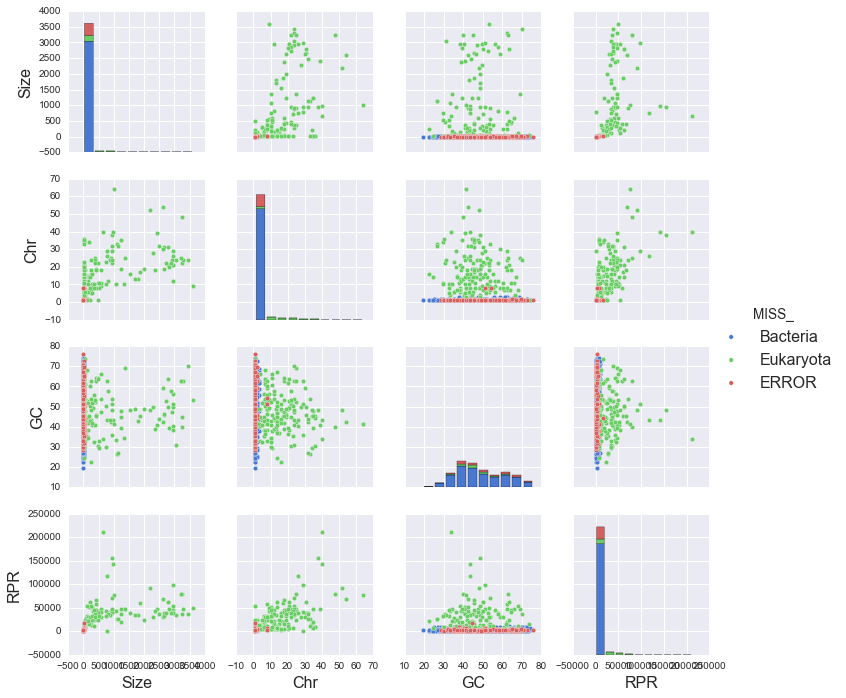

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(**rc)
sns.set(rc=rc)
sns.pairplot(df_C1D_VIS[['Size', 'Chr','GC','_Cat', 'RPR', 'MISS_']], hue="MISS_", hue_order = ["Bacteria", "Eukaryota", "ERROR"], palette="muted")


In [66]:
df_C1D_VIS.MISS_.value_counts()

Bacteria     1965
ERROR         214
Eukaryota     175
Name: MISS_, dtype: int64

In [67]:
len(df_C1D_VIS)

2354

In [68]:
# Baseline is 84%

print df_C1D_VIS._Cat.value_counts()
print 1968*1.0/len(df_C1D_VIS)

Bacteria     1968
Eukaryota     207
Archaea       179
Name: _Cat, dtype: int64
0.836023789295


Create Dataframe with elements for Confusion Matrix

In [69]:
df_T0 = pd.DataFrame(df_miss._C.value_counts()) #False Negatives Counts
df_T1 = pd.DataFrame(df_miss.predict1.value_counts()) #False Positive Counts
df_T2 = pd.DataFrame(df_predict._C.value_counts()) #Actual Test Counts
df_T3 = pd.DataFrame(df_predict.predict1.value_counts()) #Actual Predition Counts

df_T0.columns= ['FN'] #rename prediction column
df_T1.columns= ['FP'] #rename prediction column
df_T3 = pd.concat([df_T0, df_T1, df_T2, df_T3], axis=1) #Concatenate value count dataframes for t
#df_T3

In [70]:
df_CAT2 = pd.concat([df_CAT1, df_T3], axis=1, join='outer', join_axes=None, ignore_index=False,
       keys=None, levels=None, names=None, verify_integrity=False)

#Replace NaNs with 0
df_CAT2 = df_CAT2.fillna(0)

#total predictions
p_tot = df_CAT2['_C'].sum()

#Missclassification Rate = (FN + FP)/total
df_CAT2['Miss%'] = 100.*(df_CAT2['FN']+df_CAT2['FP'])/p_tot
#Accuracy = 1- Misscalc
df_CAT2['Accu%'] = 100. - df_CAT2['Miss%']
#False Positive Rate = FP/actual
df_CAT2['FP%'] = df_CAT2['FP']*100./df_CAT2['_C']
#False Negative Rate = FN/actual
df_CAT2['FN%'] = df_CAT2['FN']*100./df_CAT2['_C']
df_CAT2

,0,FN,FP,_C,predict1,Miss%,Accu%,FP%,FN%
0,Bacteria,3,211,1968,2176,9.090909,90.909091,10.721545,0.152439
1,Archaea,179,1,179,1,7.646559,92.353441,0.558659,100.000000
2,Eukaryota,32,2,207,177,1.444350,98.555650,0.966184,15.458937


Redo Leave one out KFolds with Manual Multinomial Classifier

In [182]:
def mk_RESULTS(loo_predictions, Yf):

    df_predict  = pd.DataFrame() #Dataframe with test values and predictions
    loo_predictions1_ = pd.DataFrame(data=pd.Series(loo_predictions), columns={"predict1"}) 
    Yf_ = pd.DataFrame(data=pd.Series(Yf), columns={"_C"}) 
    
    ## Dataframe with test values and predictions
    df_predict = pd.concat([Yf_, loo_predictions1_], axis=1)
    df_predict.head(5)

    ## Dataframe with just missclassification
    g = (def_comp_test(df_predict)) #Indexes of misclassifications
    df_miss = df_predict.loc[g]
    df_miss.head(5)

    ## Create Dataframe with elements for Confusion Matrix
    df_T0 = pd.DataFrame(df_miss._C.value_counts()) #False Negatives Counts
    df_T1 = pd.DataFrame(df_miss.predict1.value_counts()) #False Positive Counts
    df_T2 = pd.DataFrame(df_predict._C.value_counts()) #Actual Test Counts
    df_T3 = pd.DataFrame(df_predict.predict1.value_counts()) #Actual Predition Counts

    df_T0.columns= ['FN'] #rename prediction column
    df_T1.columns= ['FP'] #rename prediction column
    df_T3 = pd.concat([df_T0, df_T1, df_T2, df_T3], axis=1) #Concatenate value count dataframes for t
    df_T3

    ## Confusion Matrix-like Dataframe
    df_CAT2 = pd.concat([df_CAT1, df_T3], axis=1, join='outer', join_axes=None, ignore_index=False,
           keys=None, levels=None, names=None, verify_integrity=False)

    #Replace NaNs with 0
    df_CAT2 = df_CAT2.fillna(0)

    #total predictions
    p_tot = df_CAT2['_C'].sum()
    #print p_tot
    
    #Missclassification Rate = (FN + FP)/total
    df_CAT2['Miss%'] = 100.*(df_CAT2['FN']+df_CAT2['FP'])/p_tot
    #Accuracy = 1- Misscalc
    df_CAT2['Accu%'] = 100. - df_CAT2['Miss%']
    #False Positive Rate = FP/actual
    df_CAT2['FP%'] = df_CAT2['FP']*100./df_CAT2['_C']
    #False Negative Rate = FN/actual
    df_CAT2['FN%'] = df_CAT2['FN']*100./df_CAT2['_C']
    return df_CAT2



def mk_RESULTS_0(loo_predictions, loo_target):
    df_predict  = pd.DataFrame() #Dataframe with test values and predictions
    loo_predictions1_ = pd.DataFrame(data=pd.Series(loo_predictions), columns={"predict1"}) 
    Yf_ = pd.DataFrame(data=pd.Series(loo_target), columns={"_C"}) 
    
    #print loo_predictions1_.head(5)
    
    ## Dataframe with test values and predictions
    df_predict = pd.concat([Yf_, loo_predictions1_], axis=1)
    #print df_predict.head(5)

    ## Dataframe with just missclassification
    g = (def_comp_test0(df_predict)) #Indexes of misclassifications
    df_miss = df_predict.loc[g]

    return g



In [183]:
# Check Kingdom labels from NCBI versus the Tree of Life labels, especially for Viruses & Viroids

Kingdom_0 = df_sub2_['Kingdom'].tolist() #Target Series, convert to list

Taxonomy_0 = df_sub2_['Taxonomy'].tolist() #Tree of life Taxonomy, converted to list

mk_RESULTS(Taxonomy_0, Kingdom_0)

,0,FN,FP,_C,predict1,Miss%,Accu%,FP%,FN%
0,Bacteria,0.0,0.0,0.0,0.0,0.000000,100.000000,NaN,NaN
1,Eukaryota,0.0,0.0,0.0,0.0,0.000000,100.000000,NaN,NaN
2,Archaea,0.0,0.0,0.0,0.0,0.000000,100.000000,NaN,NaN
Archaea,0,0.0,0.0,176.0,176.0,0.000000,100.000000,0.000000,0.000000
Bacteria,0,17.0,68.0,1917.0,1968.0,3.615483,96.384517,3.547209,0.886802
Eukaryota,0,0.0,29.0,178.0,207.0,1.233518,98.766482,16.292135,0.000000
Viruses,0,80.0,0.0,80.0,0.0,3.402807,96.597193,0.000000,100.000000


In [60]:
g = mk_RESULTS_0(Taxonomy_0, Kingdom_0)

print len(df_sub2_.loc[g]) # dataframe with no conflicts between Kingdom NCBI and Tree of Life
print len(df_sub2_)

2257
2354


In [61]:
# Take out conflicts and reindex
df_sub2_ = df_sub2_.loc[g]
df_sub2_ = df_sub2_.dropna().reset_index(drop=True)
df_sub2_.tail(10)

,Unnamed: 0,Organism,Kingdom,Size,Chr,url,RPR,GC,Classes,Classsub1,Taxonomy,_Cat
2247,7396,Tribolium castaneum,Eukaryota,165.944000,10.0,/genome/216,22611.0,34.4,"[[, Tribolium, Tenebrioninae, Tenebrionidae, T...","[Tribolium, Tenebrioninae, Tenebrionidae, Tene...",Eukaryota,Eukaryota
2248,7400,Trichodesmium erythraeum,Bacteria,7.750110,1.0,/genome/1080,4387.0,38.9,"[[, Trichodesmium, FamilyI, SubsectionIII, Cya...","[Trichodesmium, FamilyI, SubsectionIII, Cyanob...",Bacteria,Bacteria
2249,7409,Trichormus azollae,Bacteria,5.486140,1.0,/genome/1790,3985.0,33.0,"[[, Trichormus, FamilyI, SubsectionIV, Cyanoba...","[Trichormus, FamilyI, SubsectionIV, Cyanobacte...",Bacteria,Bacteria
2250,7412,Tropheryma whipplei,Bacteria,0.927303,1.0,/genome/162,771.0,38.6,"[[, Tropheryma, Cellulomonadaceae, Micrococcal...","[Tropheryma, Cellulomonadaceae, Micrococcales,...",Bacteria,Bacteria
2251,7414,Truepera radiovictrix,Bacteria,3.260400,1.0,/genome/2158,2850.0,39.0,"[[, Truepera, Trueperaceae, Deinococcales, Dei...","[Truepera, Trueperaceae, Deinococcales, Deinoc...",Bacteria,Bacteria
2252,7415,Trueperella pyogenes,Bacteria,1.924000,1.0,/genome/16424,1920.0,38.5,"[[, Trueperella, Actinomycetaceae, Actinomycin...","[Trueperella, Actinomycetaceae, Actinomycineae...",Bacteria,Bacteria
2253,7416,Trypanosoma brucei,Eukaryota,22.148100,11.0,/genome/24,9267.0,46.0,"[[, Trypanozoon, Trypanosoma, Trypanosomatida,...","[Trypanozoon, Trypanosoma, Trypanosomatida, Me...",Eukaryota,Eukaryota
2254,7417,Tsukamurella paurometabola,Bacteria,4.479720,1.0,/genome/3379,4172.0,43.1,"[[, Tsukamurella, Tsukamurellaceae, Corynebact...","[Tsukamurella, Tsukamurellaceae, Corynebacteri...",Bacteria,Bacteria
2255,7434,Turicibacter,Bacteria,2.947470,1.0,/genome/13778,2449.0,53.5,"[[, Erysipelotrichaceae, Erysipelotrichales, E...","[Erysipelotrichaceae, Erysipelotrichales, Erys...",Bacteria,Bacteria
2256,7445,Turneriella parva,Bacteria,4.409300,1.0,/genome/11358,4132.0,55.4,"[[, Turneriella, Leptospiraceae, Spirochaetale...","[Turneriella, Leptospiraceae, Spirochaetales, ...",Bacteria,Bacteria


In [64]:
#df_sub2_.to_csv('./out_CLASSES_utf_DOMAIN.csv', encoding='utf-8')